# The aim of this notebook is to compare a classical dense FF neural network and a convolutional network in an image classification task (multiclass). I've evaluated the models on several metrics and using different data visualisation techniques. I've also explored the architecture of CNNs and its influence on model performance. Enjoy!

In [ ]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
import tensorflow as tf
from keras import initializers
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

### Optional loading of trained models, hosted on drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# baseline_model = tf.keras.models.load_model("/content/drive/MyDrive/coab_CIFAR10/baseline_keras_cifar10_trained_model.keras")
# model = tf.keras.models.load_model("/content/drive/MyDrive/coab_CIFAR10/convolutional_keras_cifar10_trained_model.keras")

In [ ]:
# import pickle

# base_save_path = "/content/drive/MyDrive/coab_CIFAR10/baseline_history.pkl"
# with open(base_save_path, 'rb') as file:
#     baseline_history = pickle.load(file)

# conv_save_path = "/content/drive/MyDrive/coab_CIFAR10/convolutional_history.pkl"
# with open(conv_save_path, 'rb') as file:
#     history = pickle.load(file)


# NN Hyperparameters

In [ ]:
batch_size = 32  # 128 # 32 works great in this case, not too much memory usage
num_classes = 10  # Number of class for the dataset
epochs = 100 # maximum, early stopping is used during training

# Loading data

In [ ]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


# converting data to float32 and normalizing, encoding labels

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# basically a one-hot encoder
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Display couple of images

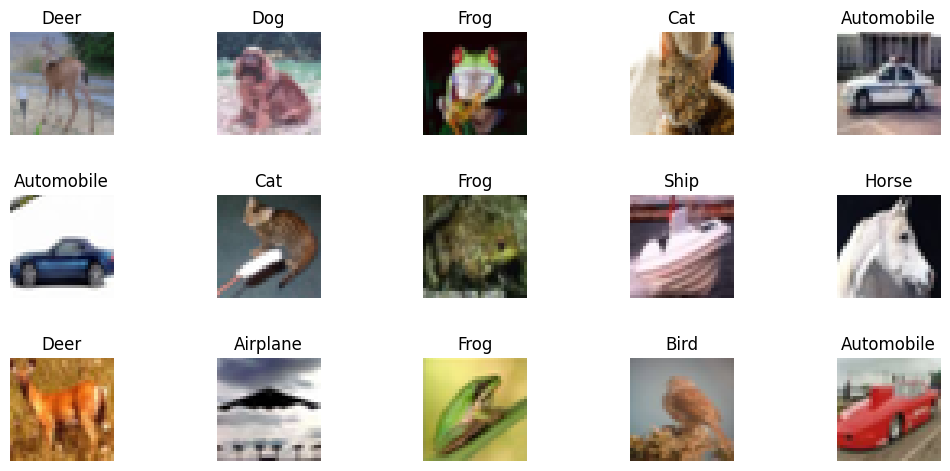

In [ ]:
def display_images(start_number, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(12, 6))
    axes = axes.ravel()
    Y_true = np.argmax(y_test, axis=1)

    for i in np.arange(0, rows * columns):
        index = start_number + i
        axes[i].imshow(x_test[index])
        axes[i].set_title(labels[Y_true[index]])
        axes[i].axis('off')
        plt.subplots_adjust(wspace=1)

    plt.show()

labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
start_number = 100  # Change this number to display images from a different starting point
rows = 3
columns = 5
display_images(start_number, rows, columns)

# Check class distribution

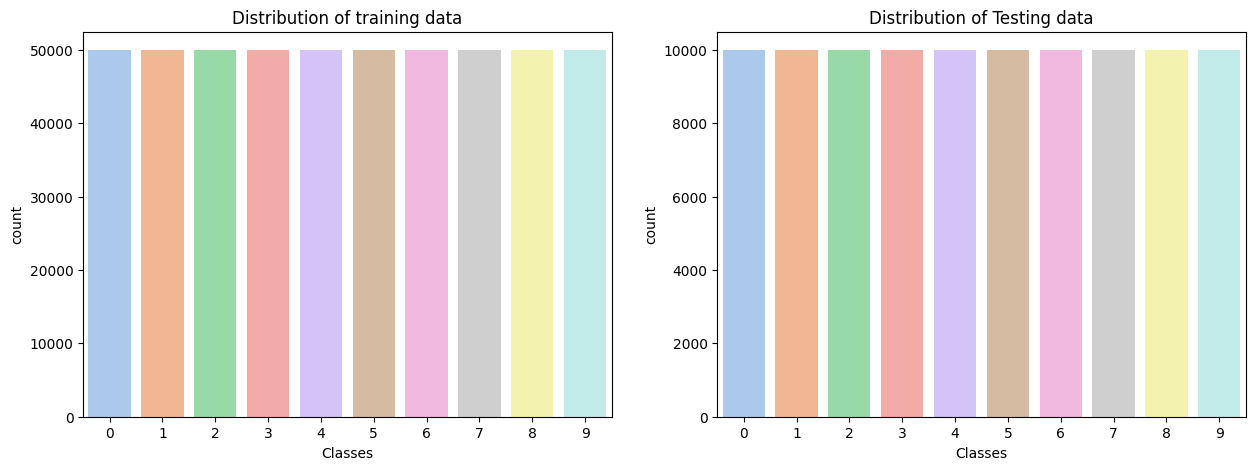

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
# training set
sns.countplot(y_train, ax=axs[0], palette=sns.color_palette("pastel"))
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# testing set
sns.countplot(y_test, ax=axs[1], palette=sns.color_palette("pastel"))
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

### Classes are balanced in this dataset

## FFNN Dense baseline model to which the model with convolutional layers will be compared

In [ ]:
baseline_model = Sequential()
baseline_model.add(Flatten(input_shape=(32, 32, 3)))
baseline_model.add(Dense(9216, activation='relu')) # yup that is a lot of parameters
baseline_model.add(Dropout(0.25))
baseline_model.add(Dense(1024, activation='relu'))
baseline_model.add(Dense(512, activation='elu',
                kernel_initializer=tf.keras.initializers.HeNormal()))
baseline_model.add(Dense(96, activation='elu', kernel_initializer=tf.keras.initializers.HeNormal()))
baseline_model.add(Dense(10, activation='softmax'))
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 9216)              28320768  
                                                                 
 dropout (Dropout)           (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              9438208   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 96)                49248     
                                                                 
 dense_4 (Dense)             (None, 10)                9

### define optimizer, early stopping callback and compile the FFNN Dense model

In [ ]:
# opt = keras.optimizers.RMSprop() # ADAM works better in this case
opt = keras.optimizers.Adam()

# add early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1, start_from_epoch=5)
# monitoring validation loss, patience set to 6 epochs and starting from epoch 5

# accuracy is the in training metric that I will be monitoring
baseline_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Baseline FFNN Dense model training

#### Classes are balanced, validation split is done in the .fit method, early stopping is used to stop training after previously established condition is reached

In [ ]:
baseline_history = None  # recording the history of trainning process.

baseline_history = baseline_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test), callbacks=[callback],
          shuffle=True)

Epoch 1/100
1563/1563 [==============================] - 31s 15ms/step - loss: 2.0174 - accuracy: 0.2881 - val_loss: 1.7573 - val_accuracy: 0.3629
Epoch 2/100
1563/1563 [==============================] - 24s 15ms/step - loss: 1.7901 - accuracy: 0.3504 - val_loss: 1.7562 - val_accuracy: 0.3638
Epoch 3/100
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7264 - accuracy: 0.3759 - val_loss: 1.6215 - val_accuracy: 0.4200
Epoch 4/100
1563/1563 [==============================] - 23s 14ms/step - loss: 1.6777 - accuracy: 0.3942 - val_loss: 1.6053 - val_accuracy: 0.4208
Epoch 5/100
1563/1563 [==============================] - 21s 14ms/step - loss: 1.6454 - accuracy: 0.4064 - val_loss: 1.5793 - val_accuracy: 0.4358
Epoch 6/100
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6233 - accuracy: 0.4161 - val_loss: 1.5580 - val_accuracy: 0.4359
Epoch 7/100
1563/1563 [==============================] - 21s 13ms/step - loss: 1.5966 - accuracy: 0.4239 - val_loss: 1

# Convolutional model definition

In [ ]:
#   A great convnet for this task, during initial testing, a lot of my early attempts
#   didn't learn at all or learned very poorly, this convnet achieves great results
#   and has somewhat repeatable and easy to understand architecture
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu')) # model.add(Activation('elu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu')) # model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # model.add(MaxPooling2D(pool_size=(3, 3))) - didn't work well
model.add(Dropout(0.25)) # model.add(Dropout(0.15))


model.add(Conv2D(64, (3, 3), padding='same')) # model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3))) # model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # model.add(Dropout(0.4)
#   tried it without dropout also but there were signs of overfitting
#   in this case dropout added AFTER pooling layers seems to increase
#   model performance


model.add(Flatten())
# model.add(Dense(1024))
# model.add(Activation('relu'))
# one dense layer works better than multiple dense layers in this case
model.add(Dense(512)) # model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier in last layers (multi-class classification)
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 32)        0         
                                                      

### Same optimizer and callback as with the FFNN Dense model, same metrics

In [ ]:
opt = keras.optimizers.Adam()

# add early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1, start_from_epoch=5)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
history = None  # For recording the history of trainning process.

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test), callbacks=[callback],
          shuffle=True)

Epoch 1/100
1563/1563 [==============================] - 18s 7ms/step - loss: 1.5153 - accuracy: 0.4448 - val_loss: 1.1780 - val_accuracy: 0.5773
Epoch 2/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1165 - accuracy: 0.6059 - val_loss: 0.9627 - val_accuracy: 0.6557
Epoch 3/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9654 - accuracy: 0.6596 - val_loss: 0.8413 - val_accuracy: 0.7058
Epoch 4/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8731 - accuracy: 0.6938 - val_loss: 0.7808 - val_accuracy: 0.7307
Epoch 5/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8105 - accuracy: 0.7146 - val_loss: 0.7534 - val_accuracy: 0.7377
Epoch 6/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7628 - accuracy: 0.7327 - val_loss: 0.7334 - val_accuracy: 0.7447
Epoch 7/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7289 - accuracy: 0.7447 - val_loss: 0.7117 -

In [ ]:
def PlotModelHistory(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # accuracy history through the epochs
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # loss history through the epochs
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

print(baseline_history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Baseline model training history

Baseline model Loss & Accuracy plot train vs val datasets 



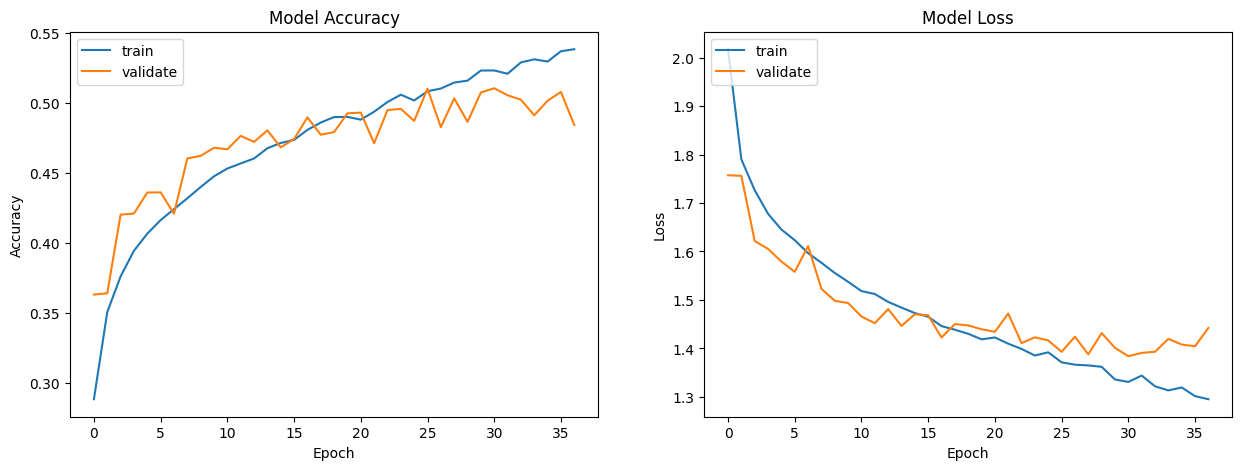

In [ ]:
print("Baseline model Loss & Accuracy plot train vs val datasets \n")
PlotModelHistory(baseline_history)

# Convolutional model training history

Convolutional model Loss & Accuracy plot train vs val datasets 



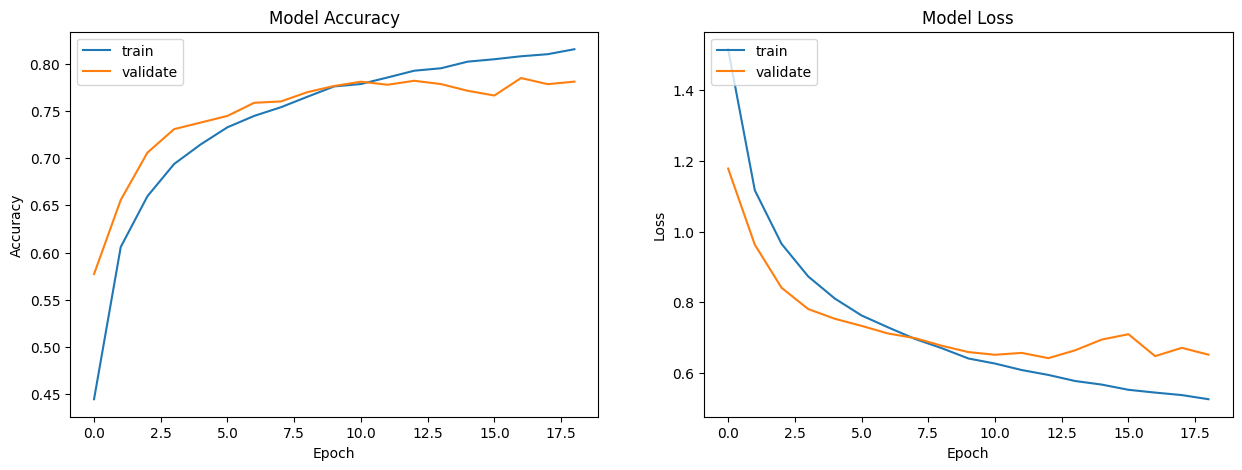

In [ ]:
print("Convolutional model Loss & Accuracy plot train vs val datasets \n")
PlotModelHistory(history)

### The convolutional model achieves better accuracy and loss values as well as taking much less time to train

# Baseline model test scores

In [ ]:
# Score trained model.
baseline_scores = baseline_model.evaluate(x_test, y_test, verbose=1)

# make prediction.
baseline_pred = baseline_model.predict(x_test)
print("\n")
print("Baseline model scores")
print(f'Test loss: {baseline_scores[0]:.4f}')
print(f'Test accuracy: {baseline_scores[1]:.4f}')

313/313 [==============================] - 1s 2ms/step


Baseline model scores
Test loss: 1.3838
Test accuracy: 0.5103


# Convolutional model test scores

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)

# make prediction.
pred = model.predict(x_test)

print("\n")
print("Convolutional model scores")
print(f"Test loss: {scores[0]:.4f}")
print(f'Test accuracy: {scores[1]:.4f}')

313/313 [==============================] - 1s 3ms/step


Convolutional model scores
Test loss: 0.6421
Test accuracy: 0.7819


## Heatmap for vizualizng model missclasification

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

In [ ]:
# Converting models predictions to one hot vectors
baseline_Y_pred_classes = np.argmax(baseline_pred, axis=1)
Y_pred_classes = np.argmax(pred, axis=1)
# Convert test observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors between predicted labels and true labels
baseline_errors = (baseline_Y_pred_classes - Y_true != 0)
errors = (Y_pred_classes - Y_true != 0)

baseline_Y_pred_classes_errors = baseline_Y_pred_classes[baseline_errors]
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

baseline_cm = confusion_matrix(Y_true, baseline_Y_pred_classes)
baseline_thresh = baseline_cm.max() / 2.

cm = confusion_matrix(Y_true, Y_pred_classes)
thresh = cm.max() / 2.


# FFNN dense model heatmap

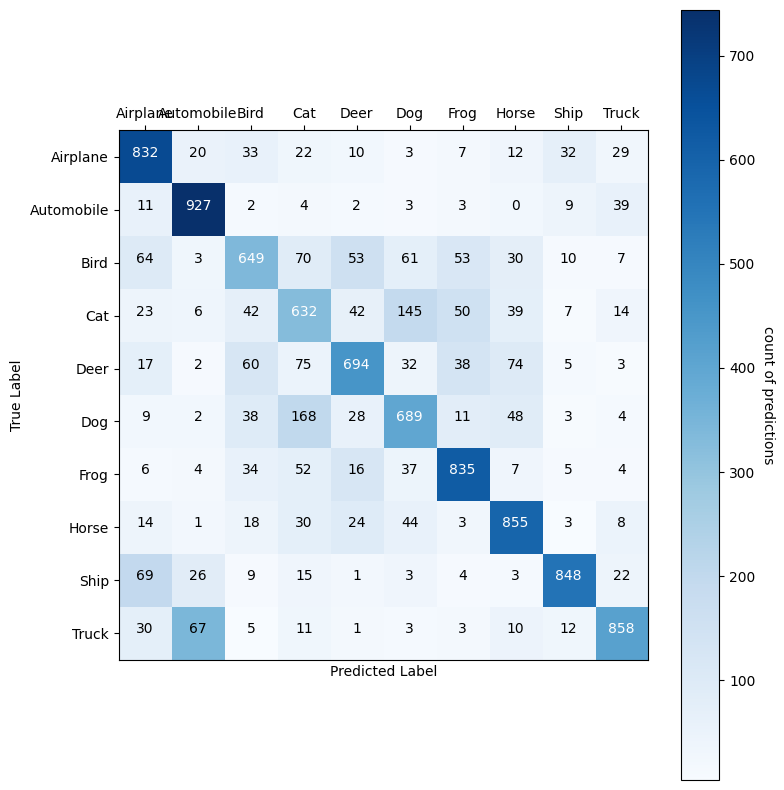

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(baseline_cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=baseline_thresh)

fig.tight_layout()
plt.show()

## Convolutional model heatmap

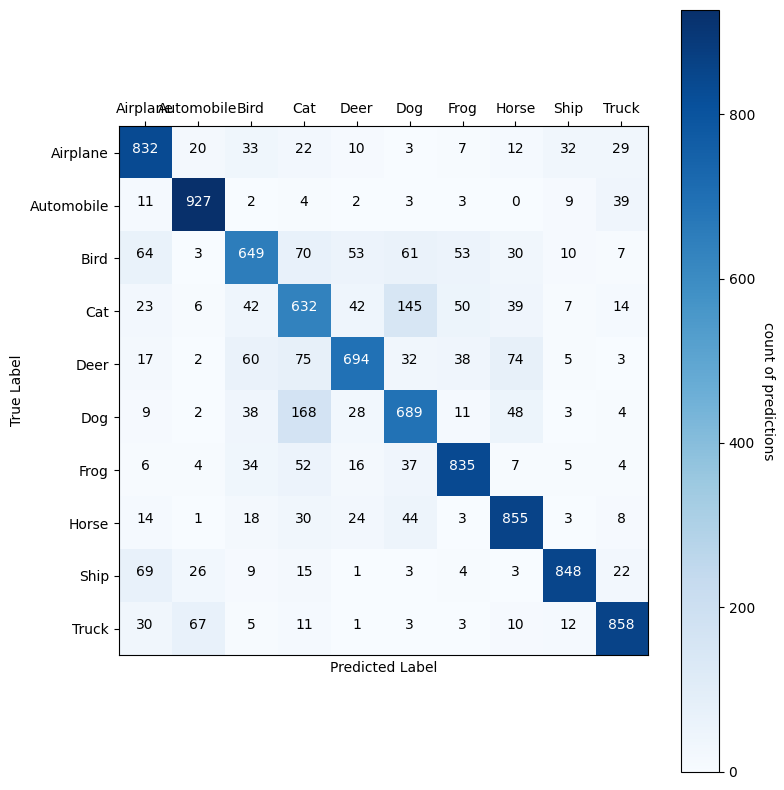

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

### the heatmap comparison illustrates that the convolutional model mispredicted less often

# Classification report for baseline model

In [ ]:
classification_report_model1 = classification_report(Y_true, baseline_Y_pred_classes)
print("Baseline model classification report: \n\n", classification_report(Y_true, baseline_Y_pred_classes))

Baseline model classification report: 

               precision    recall  f1-score   support

           0       0.52      0.67      0.59      1000
           1       0.54      0.74      0.63      1000
           2       0.42      0.34      0.37      1000
           3       0.35      0.33      0.34      1000
           4       0.44      0.45      0.45      1000
           5       0.45      0.40      0.42      1000
           6       0.52      0.62      0.56      1000
           7       0.54      0.59      0.57      1000
           8       0.74      0.55      0.63      1000
           9       0.62      0.42      0.50      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



# Classification report for convolutional model

In [ ]:
classification_report_model2 = classification_report(Y_true, Y_pred_classes)
print("Convolutional model classification report: \n\n", classification_report(Y_true, Y_pred_classes))

Convolutional model classification report: 

               precision    recall  f1-score   support

           0       0.77      0.83      0.80      1000
           1       0.88      0.93      0.90      1000
           2       0.73      0.65      0.69      1000
           3       0.59      0.63      0.61      1000
           4       0.80      0.69      0.74      1000
           5       0.68      0.69      0.68      1000
           6       0.83      0.83      0.83      1000
           7       0.79      0.85      0.82      1000
           8       0.91      0.85      0.88      1000
           9       0.87      0.86      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



# Metric differences between models

In [ ]:
Classes = np.unique(Y_true)

# Generate classification reports for both models
report_model1 = classification_report(Y_true, Y_pred_classes, target_names=Classes, output_dict=True)
report_baseline = classification_report(Y_true, baseline_Y_pred_classes, target_names=Classes, output_dict=True)

# Define the metrics you want to compare (precision, recall, F1-score)
metrics = ['precision', 'recall', 'f1-score']  # List of metrics to compare

# Calculate the differences between the metrics of the two models
differences = {metric: {} for metric in metrics}

for metric in metrics:
    differences[metric] = {
        label: report_model1[label][metric] - report_baseline[label][metric]
        for label in Classes
    }

# Map classes to the provided labels list
mapped_labels = [labels[label] for label in Classes]

# Display the differences in metrics between the two models with mapped labels
for metric in metrics:
    print(f"Difference in {metric}:")
    for idx, value in enumerate(differences[metric].values()):
        print(f"{mapped_labels[idx]}: {value:.5f}")
    print()

Difference in precision:
Airplane: 0.25249
Automobile: 0.33391
Bird: 0.31193
Cat: 0.23285
Deer: 0.35814
Dog: 0.22063
Frog: 0.31377
Horse: 0.24894
Ship: 0.17129
Truck: 0.25029

Difference in recall:
Airplane: 0.16400
Automobile: 0.18300
Bird: 0.31100
Cat: 0.30700
Deer: 0.24000
Dog: 0.29100
Frog: 0.21700
Horse: 0.26400
Ship: 0.29700
Truck: 0.44200

Difference in f1-score:
Airplane: 0.21622
Automobile: 0.27356
Bird: 0.31329
Cat: 0.26962
Deer: 0.29566
Dog: 0.25764
Frog: 0.27001
Horse: 0.25627
Ship: 0.24650
Truck: 0.36587



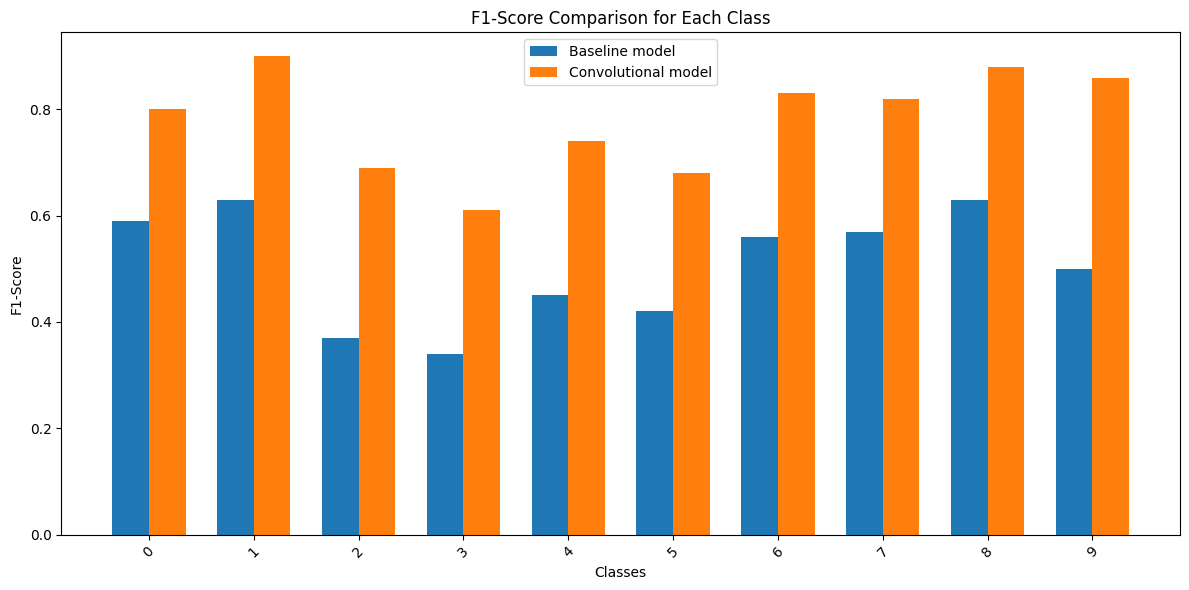

In [ ]:
# Parse the classification reports to extract metrics
def extract_metrics(classification_report):
    lines = classification_report.split('\n')
    class_names, precision, recall, f1_score, _ = [], [], [], [], []
    for line in lines[2:-5]:
        values = line.split()
        if values:
            class_names.append(values[0])
            precision.append(float(values[1]))
            recall.append(float(values[2]))
            f1_score.append(float(values[3]))
    return class_names, precision, recall, f1_score

# Extract metrics for both models
class_names_model1, _, _, f1_score_model1 = extract_metrics(classification_report_model1)
class_names_model2, _, _, f1_score_model2 = extract_metrics(classification_report_model2)

# Create a bar plot to compare F1-scores for each class
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = range(len(class_names_model1))

bar1 = ax.bar(index, f1_score_model1, bar_width, label='Baseline model')
bar2 = ax.bar([i + bar_width for i in index], f1_score_model2, bar_width, label='Convolutional model')

ax.set_xlabel('Classes')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score Comparison for Each Class')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(class_names_model1)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Baseline model prediction visualization

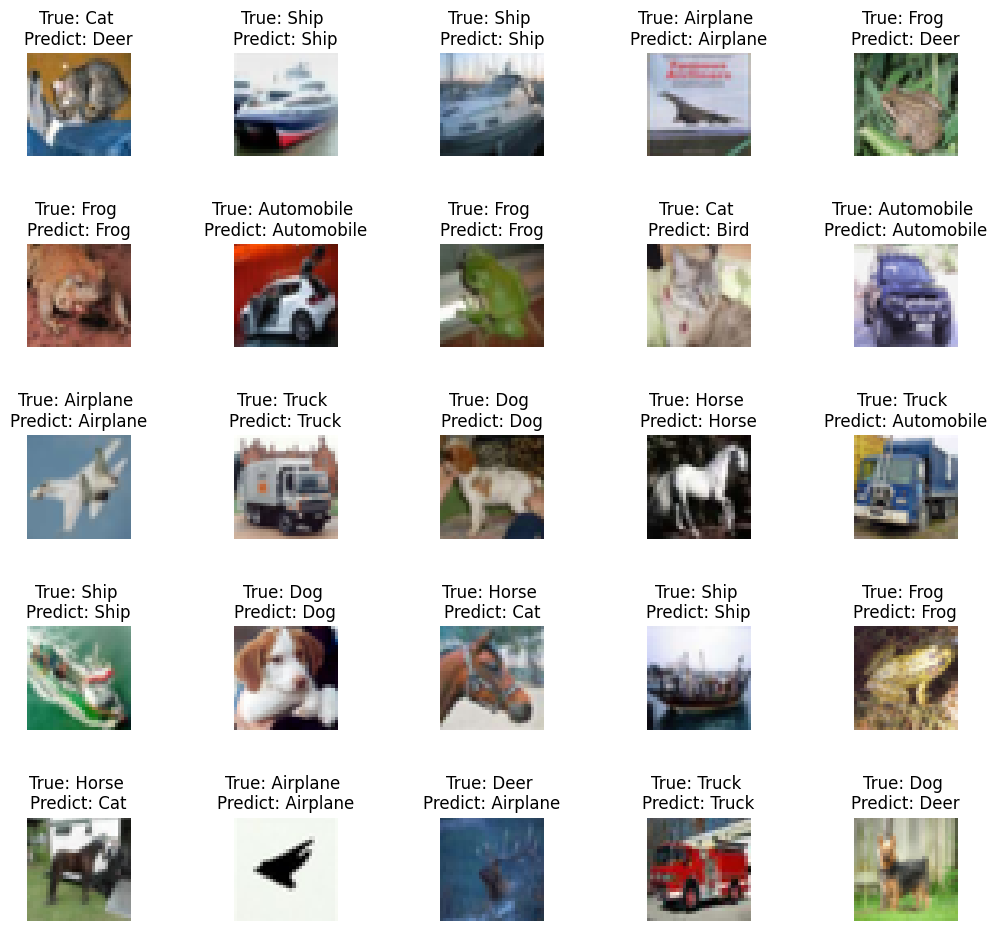

In [ ]:
rows = 5
columns = 5
fig, axes = plt.subplots(rows, columns, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, rows*columns):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[baseline_Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

### Convolutional model prediction visualization

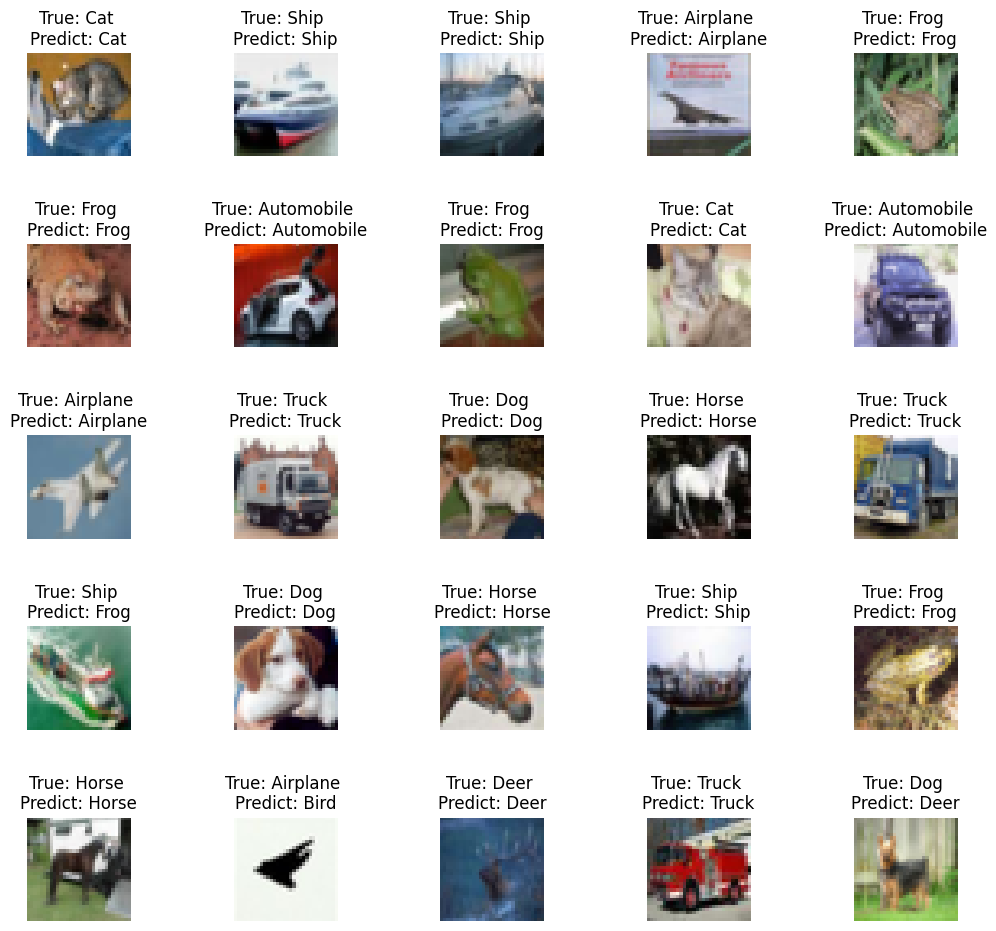

In [ ]:
rows = 5
columns = 5
fig, axes = plt.subplots(rows, columns, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, rows*columns):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

# Models size comparison

In [ ]:
# Calculate the total number of trainable parameters
total_params = sum(tf.keras.backend.count_params(p) for p in baseline_model.trainable_weights)
formatted_params = f"{total_params:,}"  # Using f-string with :, for comma separation
print(f"Baseline model total trainable parameters: {formatted_params}")

total_params = sum(tf.keras.backend.count_params(p) for p in model.trainable_weights)
formatted_params = f"{total_params:,}"  # Using f-string with :, for comma separation
print(f"Convolutional model total trainable parameters: {formatted_params}")

print("As you can see, the baseline model has much more trainable parameters and \n it performs worse than the convolutional model\n")
print("Another huge difference is in the size of the trained models, baseine model is \n 440 MB vs. the convolutional model's 14.5 MB!")

Baseline model total trainable parameters: 38,333,994
Convolutional model total trainable parameters: 1,250,858
As you can see, the baseline model has much more trainable parameters and 
 it performs worse than the convolutional model

Another huge difference is in the size of the trained models, baseine model is 
 440 MB vs. the convolutional model's 14.5 MB!


# Display couple of misclassified images - dense FFNN model

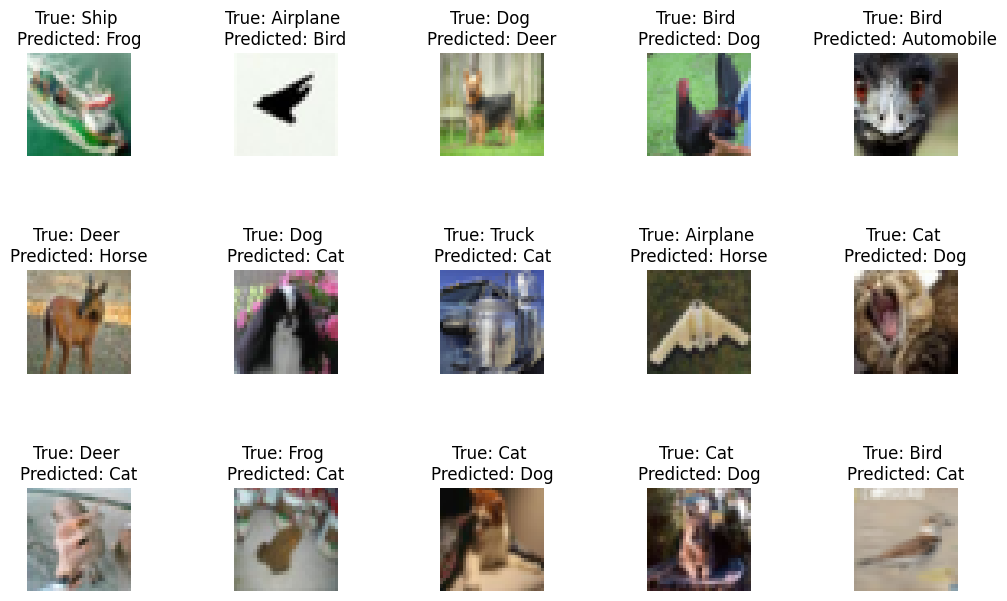

In [ ]:
rows = 3
columns = 5
fig, axes = plt.subplots(rows, columns, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, rows*columns):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]],
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

# Predicting label of image using trained models

In [ ]:
def show_test(number, baseline=None):
    fig = plt.figure(figsize=(3, 3))
    test_image = np.expand_dims(x_test[number], axis=0)
    if baseline:
        test_result = np.argmax(baseline_model.predict(test_image), axis=1)
    else:
        test_result = np.argmax(model.predict(test_image), axis=1)

    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[Y_true[number]]))

baseline model prediction: 
1/1 [==============================] - 0s 24ms/step




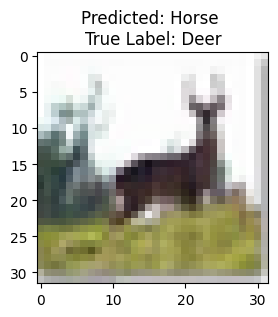

conv model prediction
1/1 [==============================] - 0s 120ms/step


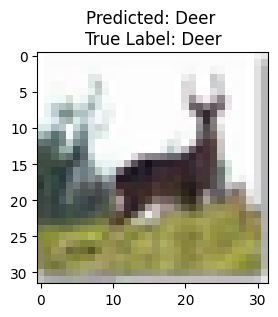

In [ ]:
img_number = 365
print("baseline model prediction: ")
show_test(img_number, baseline=True)
print("\n")
plt.show()
print("conv model prediction")
show_test(img_number) # conv model

# Save models and their's training history

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
base_model_name = 'baseline_keras_cifar10_trained_model.keras'
conv_model_name = 'convolutional_keras_cifar10_trained_model.keras'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
base_model_path = os.path.join(save_dir, base_model_name)
baseline_model.save(base_model_path)

In [ ]:
conv_model_path = os.path.join(save_dir, conv_model_name)
model.save(conv_model_path)
print(f"Saved trained model at {conv_model_path}")

Saved trained model at /content/saved_models/convolutional_keras_cifar10_trained_model.keras


In [ ]:
import os
import pickle

base_hist = 'baseline_history.pkl'


# Save the history object to a file in the specified directory using pickle
base_save_path = os.path.join(save_dir, base_hist)

with open(base_save_path, 'wb') as file:
    pickle.dump(baseline_history.history, file)

In [ ]:
conv_hist = 'convolutional_history.pkl'
conv_save_path = os.path.join(save_dir,conv_hist)
with open(conv_save_path, 'wb') as file:
    pickle.dump(history, file)

# Later, when you want to load the history object from the specified directory
with open(base_save_path, 'rb') as file:
    loaded_history = pickle.load(file)

# Summary

The convolutional model outperforms the regular FF dense model on every metric, including training time and inference time, despite having far fewer parameters and much less weight. Although its architecture is harder to visualise and understand, it's clear that using convolutional layers is very advantageous. Making changes to such large models requires a long training period, so it's best to know in advance which hyperparameter tuning / architecture changes work well.